In [ ]:
#meta: 6/29/2022 Ch 5. Intro to Neural Networks for Time Series Forecasting
#book: Machine Learning for Time Series Forecasting with Python  
#author: Francesca Lazzeri, PhD.  
#forked from FrancescaLazzeri https://github.com/FrancescaLazzeri/Machine-Learning-for-Time-Series-Forecasting  

#infra: AML anya-ml
#env azureml-timeseriesbook: Python 3.6.13 (per original env file: environment-aml.yml w/custom steps in installation doced in my 1Note)
#numpy 1.18.5, pandas 1.1.1, matplotlib 3.1.1, scikit-learn 0.22.2.post1 (did run pip freeze sklearn)
#statsmodels 0.11.1

#history
# my work through code is marked with `$my`
#6/29/2022 DEEP LEARNING
#      reuse env timeseriesbook
#      NeuralNet and Multivariate Model (1st take just like the book
#      ts predict w/ horizon (as opposed to forecast)
#      ts model evaluations
#next: review 

In [57]:
#$my python version 
import sys
print(sys.version)

3.6.13 |Anaconda, Inc.| (default, Jun  4 2021, 14:25:59) 
[GCC 7.5.0]


# Chapter 5 - Introduction to Neural Networks for Time Series Forecasting

In [1]:
import datetime as dt
import os
import warnings
from collections import UserDict

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from common.utils import load_data, mape
from IPython.display import Image
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [2]:
pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

## 0. Load Data
GEFCom 2014 energy load data  
from a local file

In [3]:
data_dir = "data/"
ts_data_load = load_data(data_dir)[["load"]]
ts_data_load.head()

,load
2012-01-01 00:00:00,"2,698.00"
2012-01-01 01:00:00,"2,558.00"
2012-01-01 02:00:00,"2,444.00"
2012-01-01 03:00:00,"2,402.00"
2012-01-01 04:00:00,"2,403.00"


## 1. Data Prep

In [4]:
valid_st_data_load = "2014-09-01 00:00:00"
test_st_data_load = "2014-11-01 00:00:00"

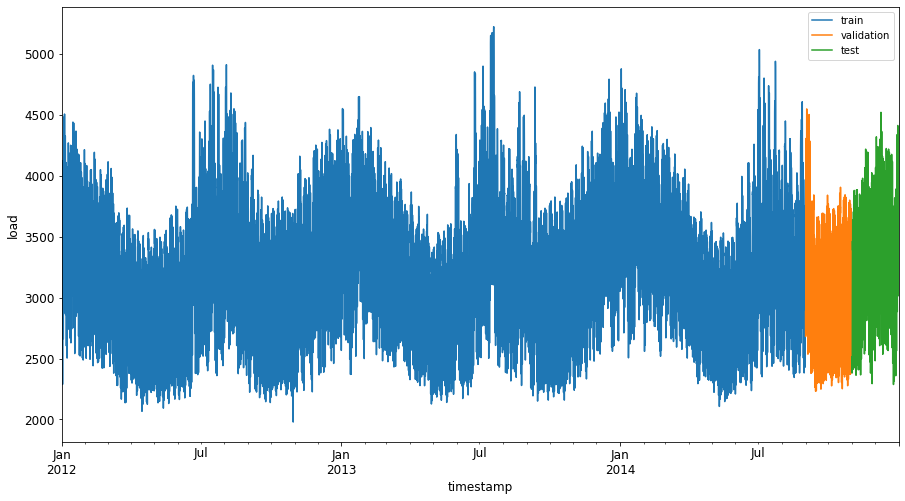

In [5]:
ts_data_load[ts_data_load.index < valid_st_data_load][["load"]].rename(columns={"load": "train"}).join(
    ts_data_load[(ts_data_load.index >= valid_st_data_load) & (ts_data_load.index < test_st_data_load)][
        ["load"]
    ].rename(columns={"load": "validation"}),
    how="outer",
).join(
    ts_data_load[test_st_data_load:][["load"]].rename(columns={"load": "test"}), how="outer"
).plot(
    y=["train", "validation", "test"], figsize=(15, 8), fontsize=12
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()

In [6]:
T = 6
HORIZON = 1
train = ts_data_load.copy()[ts_data_load.index < valid_st_data_load][["load"]]

scaler = MinMaxScaler()
train["load"] = scaler.fit_transform(train)

train_shifted = train.copy()
train_shifted["y_t+1"] = train_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    train_shifted[str(T - t)] = train_shifted["load"].shift(T - t, freq="H")
y_col = "y_t+1"
X_cols = ["load_t-5", "load_t-4", "load_t-3", "load_t-2", "load_t-1", "load_t"]
train_shifted.columns = ["load_original"] + [y_col] + X_cols

train_shifted = train_shifted.dropna(how="any")
train_shifted.head(5)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23
2012-01-01 08:00:00,0.29,0.35,0.13,0.13,0.15,0.18,0.23,0.29
2012-01-01 09:00:00,0.35,0.37,0.13,0.15,0.18,0.23,0.29,0.35


In [7]:
y_train = train_shifted[y_col].to_numpy()
X_train = train_shifted[X_cols].to_numpy()

In [8]:
X_train = X_train.reshape(X_train.shape[0], T, 1)

In [9]:
y_train.shape

(23370,)

In [10]:
y_train[:3]

array([0.18, 0.23, 0.29])

In [11]:
X_train.shape

(23370, 6, 1)

In [12]:
X_train[:3]

array([[[0.22],
        [0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15]],

       [[0.18],
        [0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18]],

       [[0.14],
        [0.13],
        [0.13],
        [0.15],
        [0.18],
        [0.23]]])

In [13]:
train_shifted.head(3)

,load_original,y_t+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t
2012-01-01 05:00:00,0.15,0.18,0.22,0.18,0.14,0.13,0.13,0.15
2012-01-01 06:00:00,0.18,0.23,0.18,0.14,0.13,0.13,0.15,0.18
2012-01-01 07:00:00,0.23,0.29,0.14,0.13,0.13,0.15,0.18,0.23


In [14]:
look_back_dt = dt.datetime.strptime(valid_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(
    hours=T - 1
)
valid = ts_data_load.copy()[(ts_data_load.index >= look_back_dt) & (ts_data_load.index < test_st_data_load)][
    ["load"]
]

valid["load"] = scaler.transform(valid)

valid_shifted = valid.copy()
valid_shifted["y+1"] = valid_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    valid_shifted["load_t-" + str(T - t)] = valid_shifted["load"].shift(T - t, freq="H")

valid_shifted = valid_shifted.dropna(how="any")
valid_shifted.head(3)

,load,y+1,load_t-5,load_t-4,load_t-3,load_t-2,load_t-1,load_t-0
2014-09-01 00:00:00,0.28,0.24,0.61,0.58,0.51,0.43,0.34,0.28
2014-09-01 01:00:00,0.24,0.22,0.58,0.51,0.43,0.34,0.28,0.24
2014-09-01 02:00:00,0.22,0.22,0.51,0.43,0.34,0.28,0.24,0.22


In [18]:
#$myfix y_valid = valid_shifted["y+1"].as_matrix()
#X_valid = valid_shifted[["load_t-" + str(T - t) for t in range(1, T + 1)]].as_matrix()
y_valid = valid_shifted["y+1"].to_numpy()
X_valid = valid_shifted[["load_t-" + str(T - t) for t in range(1, T + 1)]].to_numpy()
X_valid = X_valid.reshape(X_valid.shape[0], T, 1)

In [21]:
print(y_valid.shape)
y_valid[:3]

(1463,)


array([0.24, 0.22, 0.22])

In [22]:
print(X_valid.shape)
X_valid[:3]

(1463, 6, 1)


array([[[0.61],
        [0.58],
        [0.51],
        [0.43],
        [0.34],
        [0.28]],

       [[0.58],
        [0.51],
        [0.43],
        [0.34],
        [0.28],
        [0.24]],

       [[0.51],
        [0.43],
        [0.34],
        [0.28],
        [0.24],
        [0.22]]])

## 2a. Model: RNN

In [23]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential

In [24]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = (
    10
)

In [25]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 1)))
model.add(Dense(HORIZON))

In [26]:
model.compile(optimizer="RMSprop", loss="mse")

In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 5)                 120       
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 126
Trainable params: 126
Non-trainable params: 0
_________________________________________________________________


In [28]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

In [29]:
model_history = model.fit(
    X_train,
    y_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_valid, y_valid),
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/10
731/731 [==============================] - 2s 3ms/step - loss: 0.0053 - val_loss: 0.0011
Epoch 2/10
731/731 [==============================] - 2s 3ms/step - loss: 8.4732e-04 - val_loss: 6.3784e-04
Epoch 3/10
731/731 [==============================] - 2s 3ms/step - loss: 6.5696e-04 - val_loss: 5.4299e-04
Epoch 4/10
731/731 [==============================] - 2s 3ms/step - loss: 5.8500e-04 - val_loss: 5.1475e-04
Epoch 5/10
731/731 [==============================] - 2s 3ms/step - loss: 5.6636e-04 - val_loss: 5.8183e-04
Epoch 6/10
731/731 [==============================] - 2s 3ms/step - loss: 5.6368e-04 - val_loss: 5.4168e-04
Epoch 7/10
731/731 [==============================] - 2s 3ms/step - loss: 5.5948e-04 - val_loss: 6.8796e-04

### 2.1 Evaluate Model
on test data

In [32]:
look_back_dt = dt.datetime.strptime(test_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(
    hours=T - 1
)
test = ts_data_load.copy()[test_st_data_load:][["load"]]

test["load"] = scaler.transform(test)

test_shifted = test.copy()
test_shifted["y_t+1"] = test_shifted["load"].shift(-1, freq="H")
for t in range(1, T + 1):
    test_shifted["load_t-" + str(T - t)] = test_shifted["load"].shift(T - t, freq="H")

test_shifted = test_shifted.dropna(how="any")

y_test = test_shifted["y_t+1"].to_numpy() #$myfix .as_matrix()
X_test = test_shifted[["load_t-" + str(T - t) for t in range(1, T + 1)]].to_numpy() #$myfix .as_matrix()
X_test = X_test.reshape(X_test.shape[0], T, 1)

In [33]:
y_test.shape, X_test.shape

((1458,), (1458, 6, 1))

In [34]:
ts_predictions = model.predict(X_test)
ts_predictions

array([[0.22],
       [0.3 ],
       [0.38],
       ...,
       [0.54],
       [0.46],
       [0.43]], dtype=float32)

In [35]:
ev_ts_data = pd.DataFrame(
    ts_predictions, columns=["t+" + str(t) for t in range(1, HORIZON + 1)]
)
ev_ts_data["timestamp"] = test_shifted.index
ev_ts_data = pd.melt(ev_ts_data, id_vars="timestamp", value_name="prediction", var_name="h")
ev_ts_data["actual"] = np.transpose(y_test).ravel()
ev_ts_data[["prediction", "actual"]] = scaler.inverse_transform(
    ev_ts_data[["prediction", "actual"]]
)
ev_ts_data.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,689.59","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,957.38","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,220.38","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,352.92","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,487.30","3,436.00"


In [36]:
def mape(ts_predictions, actuals):
    """Mean absolute percentage error"""
    return ((ts_predictions - actuals).abs() / actuals).mean()

In [37]:
mape(ev_ts_data["prediction"], ev_ts_data["actual"])

0.016108245600771964

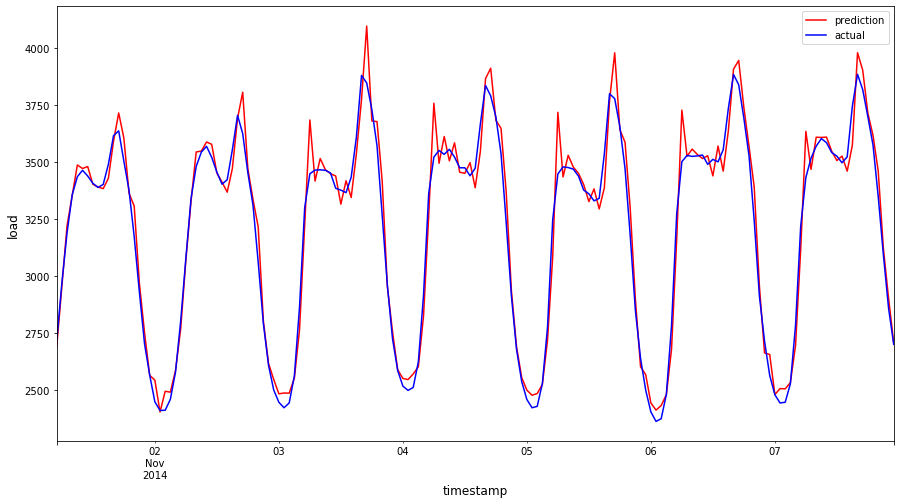

In [38]:
ev_ts_data[ev_ts_data.timestamp < "2014-11-08"].plot(
    x="timestamp", y=["prediction", "actual"], style=["r", "b"], figsize=(15, 8)
)
plt.xlabel("timestamp", fontsize=12)
plt.ylabel("load", fontsize=12)
plt.show()

## 2b. Model: Multivariate model

In [39]:
import datetime as dt
import os
import sys
import warnings
from collections import UserDict

import numpy as np
import pandas as pd
from common.utils import TimeSeriesTensor, create_evaluation_df, load_data, mape
from IPython.display import Image

pd.options.display.float_format = "{:,.2f}".format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [40]:
data_dir = "./data/"
ts_data = load_data(data_dir)
ts_data.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [41]:
valid_st_data_load = "2014-09-01 00:00:00"
test_st_data_load = "2014-11-01 00:00:00"

In [42]:
T = 6
HORIZON = 1

In [43]:
from sklearn.preprocessing import MinMaxScaler

In [44]:
y_scaler = MinMaxScaler()
y_scaler.fit(train[["load"]])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [45]:
train = ts_data.copy()[ts_data.index < valid_st_data_load][["load", "temp"]]
X_scaler = MinMaxScaler()
train[["load", "temp"]] = X_scaler.fit_transform(train)

In [46]:
train.head()

,load,temp
2012-01-01 00:00:00,0.22,0.42
2012-01-01 01:00:00,0.18,0.43
2012-01-01 02:00:00,0.14,0.40
2012-01-01 03:00:00,0.13,0.41
2012-01-01 04:00:00,0.13,0.42


In [47]:
tensor_structure = {"X": (range(-T + 1, 1), ["load", "temp"])}
ts_train_inp = TimeSeriesTensor(
    dataset=train,
    target="load",
    H=HORIZON,
    tensor_structure=tensor_structure,
    freq="H",
    drop_incomplete=True,
)
back_ts_data = dt.datetime.strptime(valid_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(
    hours=T - 1
)
valid = ts_data.copy()[(ts_data.index >= back_ts_data) & (ts_data.index < test_st_data_load)][
    ["load", "temp"]
]
valid[["load", "temp"]] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, "load", HORIZON, tensor_structure)

In [48]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.models import Model, Sequential

In [49]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 50

model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 2)))
model.add(Dense(HORIZON))

In [50]:
model.compile(optimizer="RMSprop", loss="mse")

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 5)                 135       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6         
Total params: 141
Trainable params: 141
Non-trainable params: 0
_________________________________________________________________


In [51]:
earlystop = EarlyStopping(monitor="val_loss", min_delta=0, patience=5)

In [52]:
model_history = model.fit(
    ts_train_inp["X"],
    ts_train_inp["target"],
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(valid_inputs["X"], valid_inputs["target"]),
    callbacks=[earlystop],
    verbose=1,
)

Epoch 1/50
731/731 [==============================] - 2s 3ms/step - loss: 0.0247 - val_loss: 0.0016
Epoch 2/50
731/731 [==============================] - 2s 3ms/step - loss: 0.0013 - val_loss: 9.8253e-04
Epoch 3/50
731/731 [==============================] - 2s 3ms/step - loss: 8.3062e-04 - val_loss: 9.0059e-04
Epoch 4/50
731/731 [==============================] - 2s 3ms/step - loss: 6.8662e-04 - val_loss: 6.6160e-04
Epoch 5/50
731/731 [==============================] - 2s 3ms/step - loss: 6.2406e-04 - val_loss: 5.4306e-04
Epoch 6/50
731/731 [==============================] - 2s 3ms/step - loss: 6.0093e-04 - val_loss: 6.7584e-04
Epoch 7/50
731/731 [==============================] - 2s 3ms/step - loss: 5.8145e-04 - val_loss: 5.6321e-04

In [55]:
#$myfix - Github repo not same as book
back_ts_data = dt.datetime.strptime(test_st_data_load, "%Y-%m-%d %H:%M:%S") - dt.timedelta(
    hours=T - 1
)
ts_data_test = ts_data.copy()[test_st_data_load:][["load", "temp"]]
ts_data_test[["load", "temp"]] = X_scaler.transform(ts_data_test)
ts_data_test_inputs = TimeSeriesTensor(ts_data_test, "load", HORIZON, tensor_structure)

ts_predictions = model.predict(ts_data_test_inputs["X"])

ev_ts_data = create_evaluation_df(ts_predictions, ts_data_test_inputs, HORIZON, y_scaler)
ev_ts_data.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,0.23,0.23
1,2014-11-01 06:00:00,t+1,0.31,0.31
2,2014-11-01 07:00:00,t+1,0.38,0.37
3,2014-11-01 08:00:00,t+1,0.42,0.42
4,2014-11-01 09:00:00,t+1,0.47,0.45


In [56]:
mape(ev_ts_data["prediction"], ev_ts_data["actual"])

0.051428882921823904

## Xtra

In [60]:
print(sys.path)

['/anaconda/envs/azureml-timeseriesbook/lib/python36.zip', '/anaconda/envs/azureml-timeseriesbook/lib/python3.6', '/anaconda/envs/azureml-timeseriesbook/lib/python3.6/lib-dynload', '', '/anaconda/envs/azureml-timeseriesbook/lib/python3.6/site-packages', '/anaconda/envs/azureml-timeseriesbook/lib/python3.6/site-packages/IPython/extensions', '/home/azureuser/.ipython', '/anaconda/envs/azureml-timeseriesbook/lib/python3.6/site-packages/azureml/_project/vendor', '/anaconda/envs/azureml-timeseriesbook/lib/python3.6/site-packages/azureml/automl/core/_vendor', '/anaconda/envs/azureml-timeseriesbook/lib/python3.6/site-packages/azureml/automl/runtime/_vendor']


In [59]:
#$xtra verify my custom module works
from common.my_debugger import me_print
me_print()

#if my custom module doesn't work within AML, refer to code in Notebooks/my4_Autoregressive_and_Automated_Methods_forTS_AML.ipynb

'hello world'